In [257]:
import sys
!conda install --yes --prefix {sys.prefix} lightgbm
!conda install --yes --prefix {sys.prefix} optuna
!conda install --yes --prefix {sys.prefix} shap
!conda install --yes --prefix {sys.prefix} xgboost
!conda install --yes --prefix {sys.prefix} tabgan

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - tabgan

Current channels:

  - defaults
  - https://conda.anaconda.org/conda-forge/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




### Global imports for the project

In [258]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna
import shap
import xgboost
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from xgboost import plot_importance


# Initial code to read in data and do some basic validation

### Import all raw data into a dataframe and display the first 5 rows as a sanity check.

In [259]:
# Import data
file_path = "dataset_full.csv"
phishing_df = pd.read_csv ( file_path )
phishing_df.head (20 )

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
5,1,0,0,2,0,0,0,0,0,0,...,1,3,3,3591,1,0,0,0,0,1
6,2,0,0,0,0,0,0,0,0,0,...,1,2,2,291,0,0,0,0,0,0
7,2,0,0,3,0,0,0,0,0,0,...,1,2,1,3134,1,0,0,0,0,0
8,2,0,0,0,0,0,0,0,0,0,...,1,4,2,3596,1,1,0,0,0,0
9,1,0,0,2,0,0,0,0,0,0,...,1,2,1,14397,1,0,0,0,0,1


### Look at columns and types - sanity check

In [260]:
phishing_df.dtypes

qty_dot_url             int64
qty_hyphen_url          int64
qty_underline_url       int64
qty_slash_url           int64
qty_questionmark_url    int64
                        ...  
qty_redirects           int64
url_google_index        int64
domain_google_index     int64
url_shortened           int64
phishing                int64
Length: 112, dtype: object

In [261]:
phishing_df.columns

Index(['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
       'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
       'qty_exclamation_url', 'qty_space_url',
       ...
       'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname',
       'tls_ssl_certificate', 'qty_redirects', 'url_google_index',
       'domain_google_index', 'url_shortened', 'phishing'],
      dtype='object', length=112)

# Do a mini Exploratory Data Analysis (EDA)
### Print some basic data values
### We know the data, based on the 'phishing' column, classifies each row (which representes a URL) as either phishing of legitimate

In [262]:
legitimate_count = ( phishing_df['phishing'] == 0 ).sum ()
phishing_count = ( phishing_df['phishing'] == 1 ).sum ()

print ( f"Total legitimate websites: {legitimate_count}" )
print ( f"Total phishing websites: {phishing_count}" )

Total legitimate websites: 58000
Total phishing websites: 30647


In [263]:
zero_directory_length_count = ( phishing_df['directory_length'] == 0 ).sum ()

zero_file_length_count = ( phishing_df['file_length'] == 0 ).sum ()

zero_parameters_length_count = ( phishing_df['params_length'] == 0 ).sum ()

print ( f"Number of rows where directory length is 0: {zero_directory_length_count}" )
print ( f"Number of rows where file length is 0: {zero_file_length_count}" )
print ( f"Number of rows where parameters length is 0: {zero_parameters_length_count}" )

Number of rows where directory length is 0: 0
Number of rows where file length is 0: 19624
Number of rows where parameters length is 0: 0


In [264]:
#small_rows = phishing_df[(phishing_df['length_url'] >= 0) & (phishing_df['length_url'] <= 50) & (phishing_df['phishing'] == 1)]
#one_to_fifty_count = small_rows.shape[0]
#display ( small_rows )

one_to_fifty_count = phishing_df[(phishing_df['length_url'] >= 0) & (phishing_df['length_url'] <= 50) & (phishing_df['phishing'] == 1)].shape[0]

fiftyone_to_onehundred_count = phishing_df[(phishing_df['length_url'] >= 51) & (phishing_df['length_url'] <= 100) & (phishing_df['phishing'] == 1)].shape[0]

onehundredone_to_onehundredfifty_count = phishing_df[(phishing_df['length_url'] >= 101) & (phishing_df['length_url'] <= 150) & (phishing_df['phishing'] == 1)].shape[0]

greater_than_onehundredfifty_count = phishing_df[(phishing_df['length_url'] >= 151) & (phishing_df['phishing'] == 1)].shape[0]


print ( f"Number of phishing positive rows where length of URL is 1-50 characters: {one_to_fifty_count}" )
print ( f"Number of phishing positive rows where length of URL is 51-100 characters: {fiftyone_to_onehundred_count}" )
print ( f"Number of phishing positive rows where length of URL is 101-150 characters: {onehundredone_to_onehundredfifty_count}" )
print ( f"Number of phishing positive rows where length of URL is > 150 characters: {greater_than_onehundredfifty_count}" )

Number of phishing positive rows where length of URL is 1-50 characters: 16863
Number of phishing positive rows where length of URL is 51-100 characters: 9497
Number of phishing positive rows where length of URL is 101-150 characters: 1983
Number of phishing positive rows where length of URL is > 150 characters: 2304


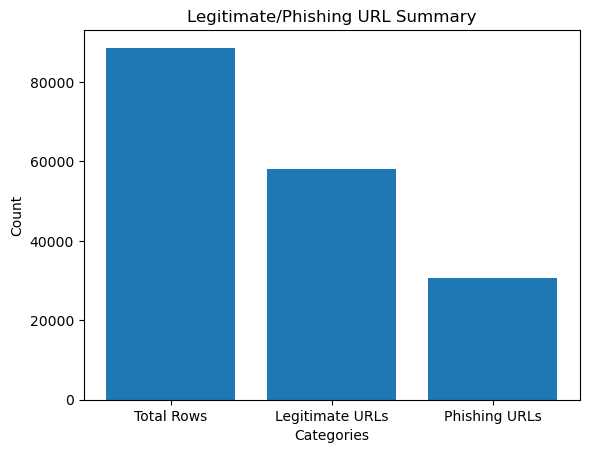

In [265]:
total_rows = phishing_df.shape[0]

counts = [total_rows, legitimate_count, phishing_count]
labels = ['Total Rows', 'Legitimate URLs', 'Phishing URLs']

plt.bar ( labels, counts )
plt.xlabel ( 'Categories' )
plt.ylabel ( 'Count' )
plt.title ( 'Legitimate/Phishing URL Summary' )
plt.show ()

### Create pie chart to show breakdown of legitimate vs phishing data rows in dataset

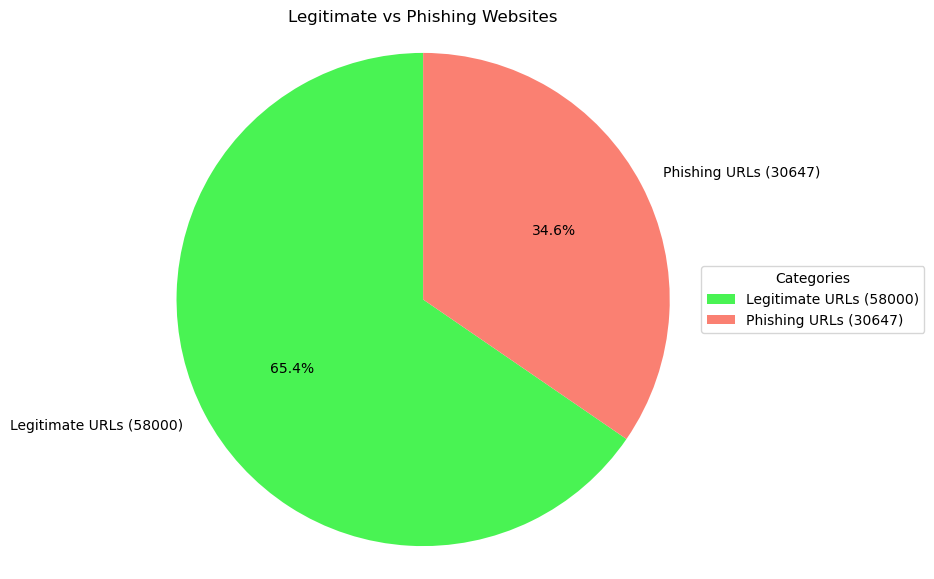

In [266]:
# Example values for legitimate_count and phishing_count
legitimate_count = 58000  # Actual count for legitimate URLs
phishing_count = 30647  # Actual count for phishing URLs

# Data for pie chart
counts = [legitimate_count, phishing_count]
labels = [f'Legitimate URLs ({legitimate_count})', f'Phishing URLs ({phishing_count})']

# Create pie chart
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#49F353', 'salmon'])
plt.title('Legitimate vs Phishing Websites')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding data on the side as a legend with actual numbers
plt.legend(wedges, labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Show the plot
plt.show()

# Look into correlation of features
### Get and print the raw correlation matrix

In [267]:
correlations = phishing_df.corr ().abs() #['phishing'].drop ( 'phishing' )
#correlations = phishing_df.corr().abs()['phishing'].drop('phishing')
print ( correlations )

                      qty_dot_url  qty_hyphen_url  qty_underline_url  \
qty_dot_url              1.000000        0.109737           0.127851   
qty_hyphen_url           0.109737        1.000000           0.213589   
qty_underline_url        0.127851        0.213589           1.000000   
qty_slash_url            0.246201        0.304762           0.246653   
qty_questionmark_url     0.409549        0.061247           0.067009   
...                           ...             ...                ...   
qty_redirects            0.051842        0.001930           0.013864   
url_google_index         0.004035        0.002939           0.001823   
domain_google_index      0.002490        0.006875           0.003421   
url_shortened            0.059222        0.010346           0.012158   
phishing                 0.171128        0.200382           0.191151   

                      qty_slash_url  qty_questionmark_url  qty_equal_url  \
qty_dot_url                0.246201              0.409549  

In [268]:
def create_top_pairs ( corr_matrix ):
    # Get the top n pairs with the highest correlation
    n = 10 # change this to the number of pairs you want to get

    top_pairs = corr_matrix.unstack ().sort_values ( ascending=False )#[:n * 2]
#    print ( top_pairs )

    unique_pairs = []

    pair_count = 0
    # Iterate over the top pairs and add only unique pairs to the list
    for pair in top_pairs.index:
        if pair[0] != pair[1] and ( pair[1], pair[0] ) not in unique_pairs:
#            print (f'Adding pair: {pair}')
            unique_pairs.append ( pair )
            pair_count += 1
            if pair_count >= n:
                break
            
    # Create a dataframe with the top pairs and their correlation coefficients
    top_pairs_df = pd.DataFrame ( columns=['feature_1', 'feature_2', 'corr_coef'] )
    for i, pair in enumerate ( unique_pairs[:n] ):
#        print ( f'{pair[0]}, {pair[1]}, {corr_matrix.loc[pair[0], pair[1]]}' )
        top_pairs_df.loc[i] = [pair[0], pair[1], corr_matrix.loc[pair[0], pair[1]]]

    return top_pairs_df

raw_top_pairs_df = create_top_pairs ( correlations )

# Print the top pairs as a dataframe
display ( raw_top_pairs_df )

,feature_1,feature_2,corr_coef
0,qty_hashtag_directory,qty_questionmark_file,1.0
1,qty_questionmark_directory,qty_dollar_file,1.0
2,qty_hashtag_directory,qty_questionmark_directory,1.0
3,qty_hashtag_directory,qty_slash_file,1.0
4,qty_hashtag_directory,qty_hashtag_file,1.0
5,qty_questionmark_directory,qty_questionmark_file,1.0
6,qty_hashtag_directory,qty_dollar_file,1.0
7,qty_slash_file,qty_questionmark_directory,1.0
8,qty_slash_file,qty_questionmark_file,1.0
9,qty_slash_file,qty_hashtag_file,1.0


## 112 columns it too much to work with initially. We need to remove some of the data.
### Need to removed highly correlated data. This code does that.
### Takes data points from 112 columns to 66

In [269]:
droplist = []
keeplist = []
for col in correlations.columns:
    # print(correlation_matrix[col])
    gt80_index = correlations.loc[correlations[col]>=.80].index
    for ind in gt80_index:
        if ind!=col and ind not in keeplist:
            droplist.append(ind)
        else:
            keeplist.append(col)
            # df.drop(columns=[ind], inplace=True)
            # correlation_matrix = abs(df.corr())
droplist = list(set(droplist))
phishing_df.drop(columns=droplist, inplace=True)

phishing_df

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_exclamation_url,qty_space_url,qty_tilde_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,0,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,0,0,0,0,0,0,0,...,1,3,1,3597,0,0,0,0,0,0
88643,2,0,0,0,0,0,0,0,0,0,...,1,2,2,591,0,2,0,0,0,0
88644,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


### We can remove columns where the value is 0 for every row. This data adds no value.

In [270]:
# Drop all columsn where every value in the column is 0
# Note that this should only be columns that start with 'qty_'
columns_all_zeros = phishing_df.loc[:, phishing_df.eq ( 0 ).all ()]
#print ( columns_all_zeros )
phishing_df.drop ( columns_all_zeros.columns, axis=1, inplace=True )

phishing_df.to_csv ( 'filtered_dataset.csv', index=False )

phishing_df


,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_exclamation_url,qty_space_url,qty_tilde_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,0,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,0,0,0,0,0,0,0,...,1,3,1,3597,0,0,0,0,0,0
88643,2,0,0,0,0,0,0,0,0,0,...,1,2,2,591,0,2,0,0,0,0
88644,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


### The final dataset to work with initially is 53 columns.
### Show the correlation matrix for these columns.

In [271]:
correlation_matrix = phishing_df.corr ()
mask = np.zeros_like(correlation_matrix, dtype=bool)

mask[np.triu_indices_from(mask)] = True

correlation_matrix[mask] = np.nan
(correlation_matrix
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_at_domain,qty_vowels_domain,domain_in_ip,server_client_domain,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_percent_directory,directory_length,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_percent_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
qty_dot_url,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_hyphen_url,0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_underline_url,0.13,0.21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_slash_url,0.25,0.30,0.25,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_questionmark_url,0.41,0.06,0.07,0.18,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_equal_url,0.50,0.18,0.33,0.29,0.46,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_at_url,0.17,0.04,0.06,0.10,0.13,0.17,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_exclamation_url,0.00,0.02,0.06,0.03,0.02,0.05,0.19,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_space_url,-0.00,0.02,-0.00,0.02,0.00,0.01,0.00,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
qty_tilde_url,0.03,0.01,0.04,0.07,0.00,0.00,0.02,0.08,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [272]:
filtered_corr_matrix = phishing_df.corr ()

filtered_top_pairs_df = create_top_pairs ( filtered_corr_matrix )

# Print the top pairs as a dataframe
display ( filtered_top_pairs_df )

,feature_1,feature_2,corr_coef
0,qty_percent_url,qty_percent_directory,0.793843
1,qty_hyphen_directory,qty_hyphen_url,0.747148
2,qty_underline_url,qty_underline_params,0.741784
3,qty_questionmark_params,qty_dot_params,0.736039
4,qty_slash_url,directory_length,0.729849
5,qty_equal_url,qty_questionmark_params,0.719497
6,qty_equal_url,qty_dot_params,0.714725
7,qty_dot_url,qty_dot_params,0.709904
8,qty_slash_url,qty_dot_directory,0.704592
9,qty_slash_params,qty_questionmark_params,0.699622


# Machine Learning Models
## Three models will be used for this project: RandomForest, LightGBM, and XGBoost
### Start with RandomForest because it is the easiest.

In [273]:
# Define the features (X) and target (y)
X = phishing_df.drop(columns='phishing')  # Features are all columns except 'phishing'
y = phishing_df['phishing']    

In [274]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### First look using a RandomForestClassifier

In [275]:
# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [276]:
# Extract feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

In [277]:
print ( importances )

[1.10978059e-02 1.08018330e-02 4.32432443e-03 8.46341217e-02
 2.07899361e-05 4.11503886e-03 2.50702473e-04 9.89505685e-05
 3.47316088e-06 1.13536102e-04 1.19637782e-04 2.67349950e-04
 1.94424888e-05 1.97774935e-06 1.21588523e-05 9.43800594e-04
 2.16318116e-03 6.70718717e-02 1.89990376e-02 3.36110798e-03
 1.16987613e-05 2.14621071e-06 1.65645312e-02 3.92327224e-04
 1.05479978e-04 6.05818901e-02 7.79496319e-02 7.73770007e-02
 7.75624763e-02 1.32664108e-01 8.07645161e-02 5.94076021e-03
 2.68409373e-03 5.71587865e-03 1.99495565e-03 2.37138188e-03
 6.51565469e-03 4.05383460e-04 2.66327873e-02 5.11212352e-03
 2.57989122e-02 8.31527422e-02 2.34851409e-02 8.98791597e-03
 1.25861414e-02 1.27244170e-02 2.77509315e-02 6.14016061e-03
 8.14833055e-03 1.41502246e-04 7.06697222e-05 1.24416858e-03]


### List feature importance in sorted order

In [278]:
# Rank features by importance and display them
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                    Feature  Importance
29         directory_length    0.132664
3             qty_slash_url    0.084634
41   time_domain_activation    0.083153
30              file_length    0.080765
26     qty_hyphen_directory    0.077950
28    qty_percent_directory    0.077562
27  qty_underline_directory    0.077377
17               length_url    0.067072
25        qty_dot_directory    0.060582
46             ttl_hostname    0.027751
38            time_response    0.026633
40                   asn_ip    0.025799
42   time_domain_expiration    0.023485
18           qty_dot_domain    0.018999
22        qty_vowels_domain    0.016565
45           qty_mx_servers    0.012724
44          qty_nameservers    0.012586
0               qty_dot_url    0.011098
1            qty_hyphen_url    0.010802
43          qty_ip_resolved    0.008988
48            qty_redirects    0.008148
36       qty_percent_params    0.006516
47      tls_ssl_certificate    0.006140
31           qty_dot_params    0.005941


### Show a chart of all features that RandomForest thinks is important, in soreted order

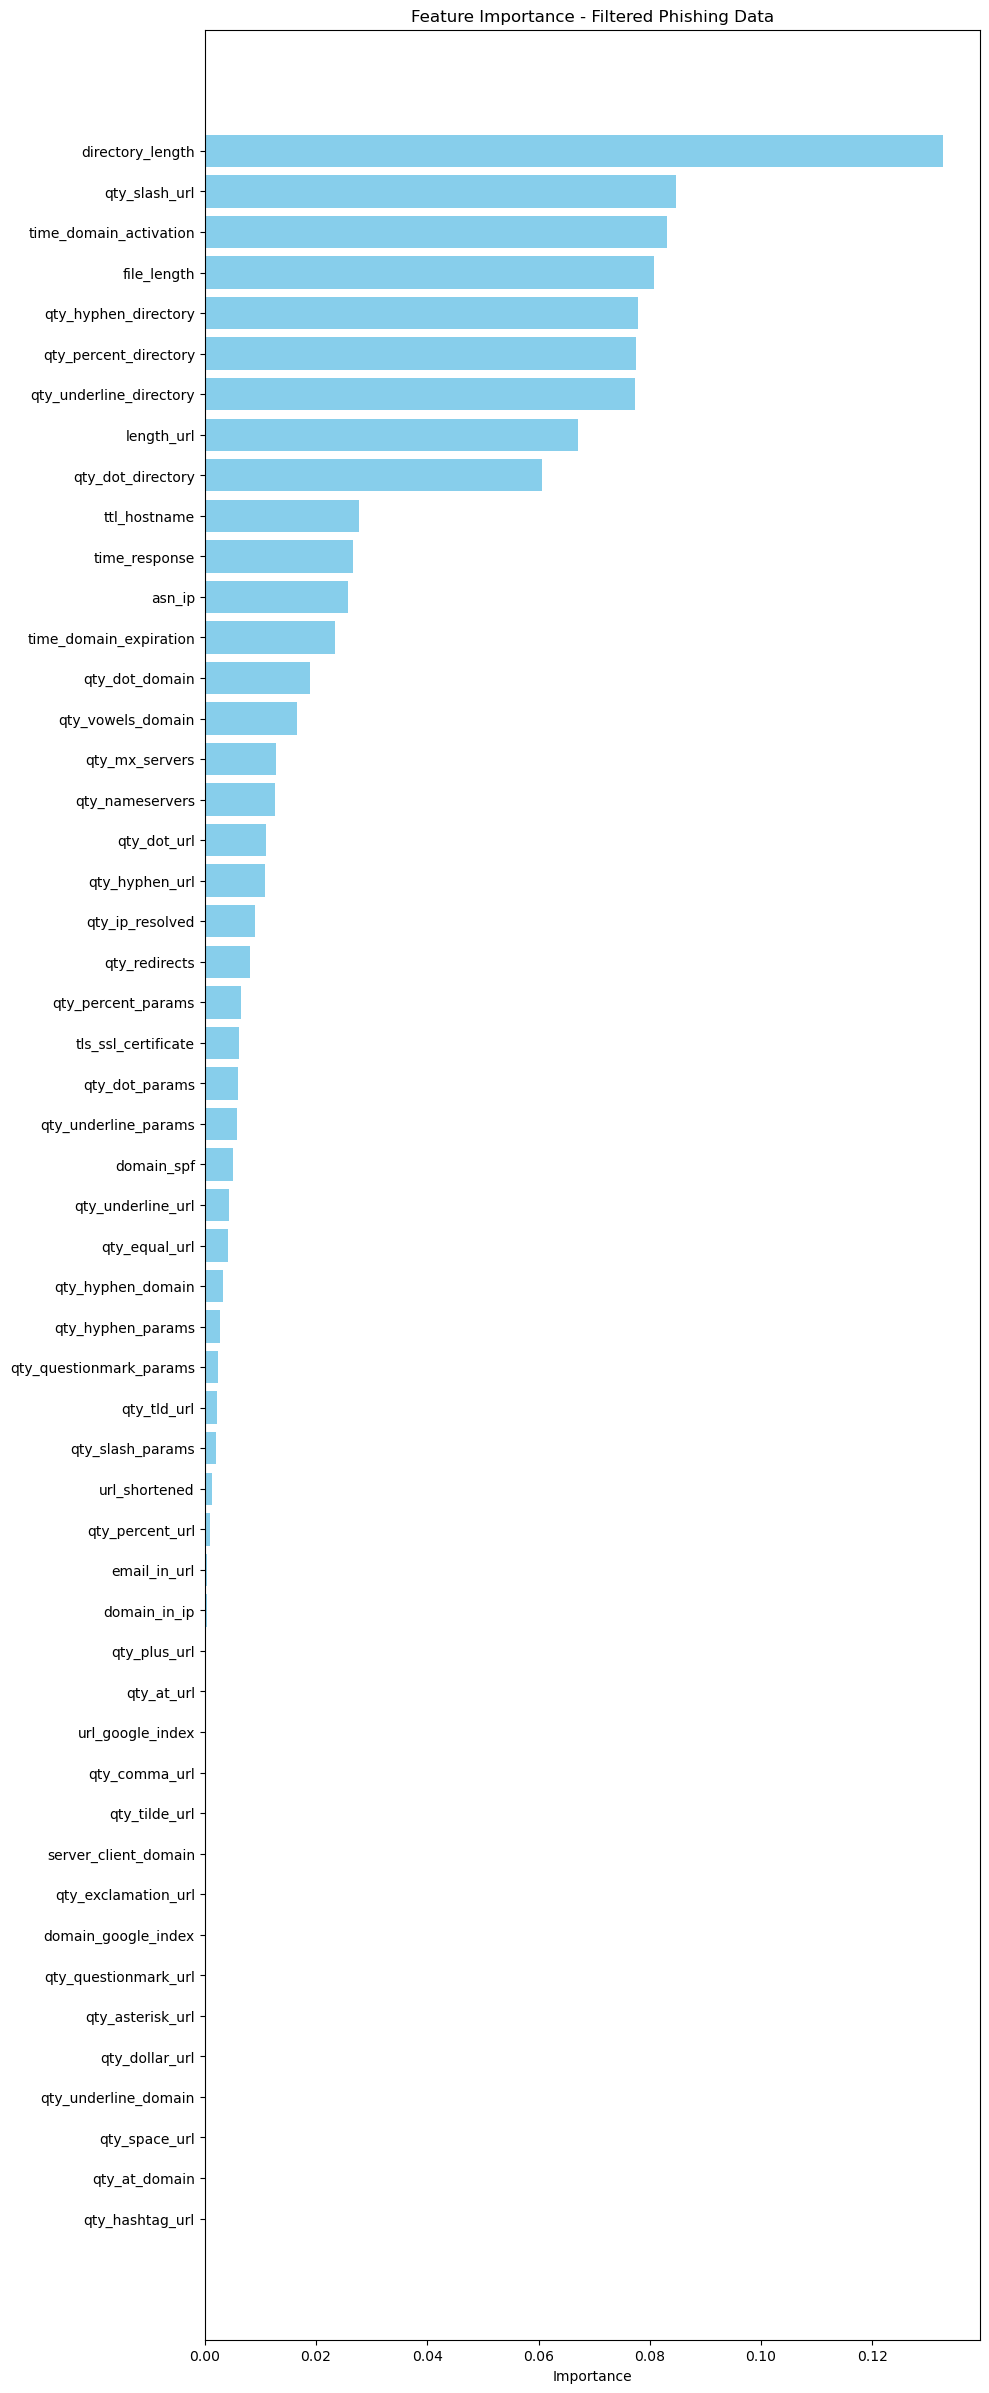

In [279]:
# Create a bar plot for feature importance
plt.figure(figsize=(10, 30))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance - Filtered Phishing Data')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

## Show only the top 10 important features generated by RandomForest

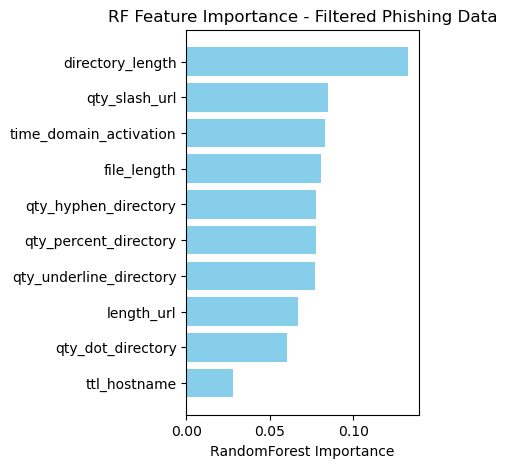

In [280]:
# Create a bar plot for feature importance
#print(type(feature_importance_df["Feature"]))

df_features = feature_importance_df.iloc[0:10, [0]].squeeze ()

#feature_importance_df["Feature"]
df_importances = feature_importance_df.iloc[0:10, [1]].squeeze ()
#print (df_importances)

plt.figure(figsize=(3, 5))
plt.barh(df_features, df_importances, color='skyblue')
plt.xlabel('RandomForest Importance')
plt.title('RF Feature Importance - Filtered Phishing Data')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

### Look at initial scores

In [281]:
# Evaluate the model before feature selection
accuracy_before = rf.score(X_test, y_test)
print(f'Accuracy of TEST data before feature selection: {accuracy_before:.2f}')

Accuracy of TEST data before feature selection: 0.97


In [282]:
# Evaluate the model before feature selection
accuracy_before = rf.score(X_train, y_train)
print(f'Accuracy of TRAIN data before feature selection: {accuracy_before:.2f}')

Accuracy of TRAIN data before feature selection: 1.00


In [283]:
# Select top N features (example selecting top 10 features)
top_features = feature_importance_df['Feature'][:10].values
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [284]:
# Train the Random Forest model with selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [285]:
# Evaluate the model after feature selection
accuracy_after = rf_selected.score(X_test_selected, y_test)
print(f'Accuracy of TEST after feature selection: {accuracy_after:.2f}')

Accuracy of TEST after feature selection: 0.96


In [286]:
# Evaluate the model after feature selection
accuracy_after = rf_selected.score(X_train_selected, y_train)
print(f'Accuracy of TEST after feature selection: {accuracy_after:.2f}')

Accuracy of TEST after feature selection: 1.00


In [287]:
# Create the Random Forest classifier model with a random_state for reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Calculate training accuracy
train_accuracy = rf_model.score(X_train, y_train)

# Calculate testing accuracy
test_accuracy = rf_model.score(X_test, y_test)

# Validate the model by checking the model accuracy with model.score
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

Train Accuracy: 1.000
Test Accuracy: 0.969


# LightGBM - Training and Testing using the lightgbm model
## Set up the model and show initial accuracy and precision

In [288]:
# Define the features (X) and target (y)
X = phishing_df.drop ( columns='phishing' )  # Features are all columns except 'phishing'
y = phishing_df['phishing']  

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size=0.3, random_state=42 )


In [289]:
# Create LightGBM datasets for training and testing
train_data = lgb.Dataset ( X_train, label=y_train )
test_data = lgb.Dataset ( X_test, label=y_test, reference=train_data )

In [290]:
# Define hyperparameters
params = {
    "objective": "binary",
    "boosting_type": "rf",
    "num_leaves": 5,
    "force_row_wise": True,
    "learning_rate": 0.5,
    "metric": "binary_logloss",
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8
}

# Train the LightGBM model
num_round = 500
bst = lgb.train ( params, train_data, num_round, valid_sets=[test_data] )

In [291]:
# Make predictions
y_train_pred = bst.predict ( X_train )
y_test_pred = bst.predict ( X_test )

# Convert probabilities to binary predictions
y_train_pred_binary = ( y_train_pred > 0.5 ).astype ( int )
y_test_pred_binary = ( y_test_pred > 0.5 ).astype ( int )

# Evaluate model
test_accuracy = accuracy_score ( y_test, y_test_pred_binary )
train_accuracy = accuracy_score ( y_train, y_train_pred_binary )
precision = precision_score ( y_test, y_test_pred_binary )
recall = recall_score ( y_test, y_test_pred_binary )
f1score = f1_score ( y_test, y_test_pred_binary )

# Print metrics
print(f"Accuracy of TRAIN before feature selection: {train_accuracy:.4f}")
print(f"Accuracy of TEST before feature selection: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1score:.4f}")


Accuracy of TRAIN before feature selection: 0.9196
Accuracy of TEST before feature selection: 0.9187
Precision: 0.8409
Recall: 0.9416
F1-Score: 0.8884


In [292]:
# Generate classification report
report = classification_report(y_test, y_pred_binary)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     17449
           1       0.84      0.94      0.89      9146

    accuracy                           0.92     26595
   macro avg       0.90      0.92      0.91     26595
weighted avg       0.92      0.92      0.92     26595



## Similar to what was done with RandomForest, get and show feature importance

In [293]:
feature_importance = bst.feature_importance(importance_type='gain')

# Get feature names
feature_names = bst.feature_name()

# Create a DataFrame of feature importance and names
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Get the top 10 important features
top_10_features = importance_df['feature'].head(10).tolist()

print("Top 10 important features:", top_10_features)

Top 10 important features: ['directory_length', 'qty_slash_url', 'time_domain_activation', 'qty_dot_directory', 'length_url', 'qty_dot_domain', 'qty_hyphen_directory', 'file_length', 'qty_underline_directory', 'ttl_hostname']


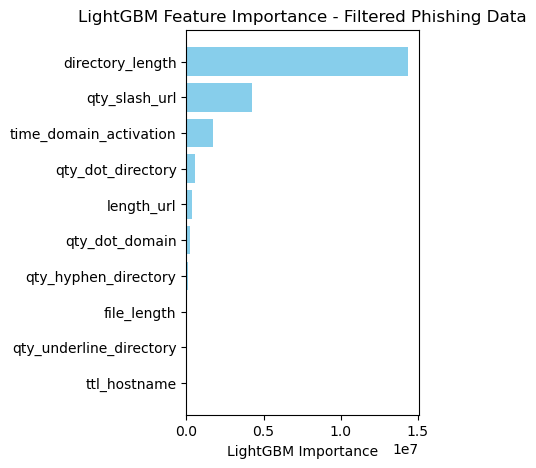

In [294]:
# Sort by importance in descending order and get the top 10 features
lgbm_top_10_importance_df = importance_df.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(3, 5))
plt.barh(lgbm_top_10_importance_df['feature'], lgbm_top_10_importance_df['importance'], color='skyblue')
plt.xlabel('LightGBM Importance')
plt.title('LightGBM Feature Importance - Filtered Phishing Data')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [295]:
# Define the features (X) and target (y)
X = phishing_df.drop ( columns='phishing' )  # Features are all columns except 'phishing'
y = phishing_df['phishing']

lgbm_feature_X = X[top_10_features]

# Split the dataset
lgbm_feature_X_train, lgbm_feature_X_test, lgbm_feature_y_train, lgbm_feature_y_test = train_test_split ( lgbm_feature_X, y, test_size=0.3, random_state=42 )


In [296]:
lgbm_train_data_top_10 = lgb.Dataset ( lgbm_feature_X_train, label=y_train )
lgbm_test_data_top_10 = lgb.Dataset ( lgbm_feature_X_test, label=y_test, reference=lgbm_train_data_top_10 )

# Retrain the model
lgbm_model_top_10 = lgb.train(params, lgbm_train_data_top_10, num_boost_round=100)

# Now, the model is trained using only the top 10 features.

In [297]:
y_train_top_10_pred = lgbm_model_top_10.predict ( lgbm_feature_X_train )
y_test_top_10_pred = lgbm_model_top_10.predict ( lgbm_feature_X_test )

# Convert probabilities to binary predictions
y_train_top_10_pred_binary = ( y_train_top_10_pred > 0.5 ).astype ( int )
y_test_top_10_pred_binary = ( y_test_top_10_pred > 0.5 ).astype ( int )

# Evaluate model
test_top_10_accuracy = accuracy_score ( lgbm_feature_y_test, y_test_top_10_pred_binary )
train_top_10_accuracy = accuracy_score ( lgbm_feature_y_train, y_train_top_10_pred_binary )
precision = precision_score ( lgbm_feature_y_test, y_test_top_10_pred_binary )
recall = recall_score ( lgbm_feature_y_test, y_test_top_10_pred_binary )
f1score = f1_score ( lgbm_feature_y_test, y_test_top_10_pred_binary )

# Print metrics
print(f"Accuracy of TEST after feature set: {test_top_10_accuracy:.4f}")
print(f"Accuracy of TRAIN after feature set: {train_top_10_accuracy:.4f}")
print(f"Precision after feature set: {precision:.4f}")
print(f"Recall after feature set: {recall:.4f}")
print(f"F1-Score after feature set: {f1score:.4f}")

Accuracy of TEST after feature set: 0.9187
Accuracy of TRAIN after feature set: 0.9196
Precision after feature set: 0.8409
Recall after feature set: 0.9416
F1-Score after feature set: 0.8884


In [298]:
# Generate classification report
report = classification_report(lgbm_feature_y_test, y_test_top_10_pred_binary)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     17449
           1       0.84      0.94      0.89      9146

    accuracy                           0.92     26595
   macro avg       0.90      0.92      0.91     26595
weighted avg       0.92      0.92      0.92     26595



## This is an interesting code feature which can be used to fine tune the LightGBM model. This quickly spins through various parameter settings and comes up with an optimal set of parameters for the model.

In [299]:

classifier = None

def objective (
    trial: optuna.Trial,
    train_dataset: lgb.Dataset,
    val_dataset: lgb.Dataset,
    val_x_df: pd.DataFrame,
    val_y: np.ndarray,
) -> float:
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1, step=0.1),
        "verbose": -1
    }
    
    global classifier
    classifier = lgb.train (
        params,
        train_dataset,
        valid_sets=[val_dataset],
        callbacks=[
            lgb.early_stopping(
                20,
                verbose=False,
            ),
        ],
    )

    y_pred = classifier.predict(val_x_df)
    pred_labels = np.rint(y_pred)
    return accuracy_score(val_y, pred_labels)


# Create the train and validation datasets
train_dataset = lgb.Dataset(X_train, y_train, params={'verbose': -1}, free_raw_data=False)
val_dataset = lgb.Dataset(X_test, y_test, reference=train_dataset, params={'verbose': -1}, free_raw_data=False)

# Define the objective function
objective_func = lambda trial: objective(
    trial,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    val_x_df=X_test,
    val_y=y_test,
)

# Run the optimisation
study = optuna.create_study()
study.optimize(objective_func, n_trials=100)

# Get the best hyperparameters
print(study.best_params)

[I 2024-09-10 20:52:57,257] A new study created in memory with name: no-name-71ac9531-5d37-4e79-bce8-dce212b90dfe
[I 2024-09-10 20:52:57,660] Trial 0 finished with value: 0.9508178228990412 and parameters: {'learning_rate': 0.17, 'min_data_in_leaf': 7800, 'max_depth': 10, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.9508178228990412.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[I 2024-09-10 20:52:58,500] Trial 1 finished with value: 0.9662718556119572 and parameters: {'learning_rate': 0.26, '

{'learning_rate': 0.01, 'min_data_in_leaf': 10000, 'max_depth': 3, 'feature_fraction': 0.5}


## Some interesting graphics showing feature imporance.

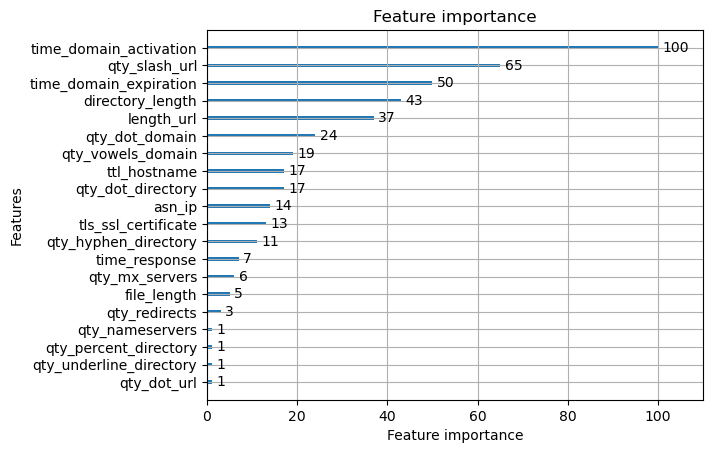

In [300]:
# Code to plot feature importance based on the classifier used in the 'study'
# done above
lgb.plot_importance ( classifier )
plt.show ()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


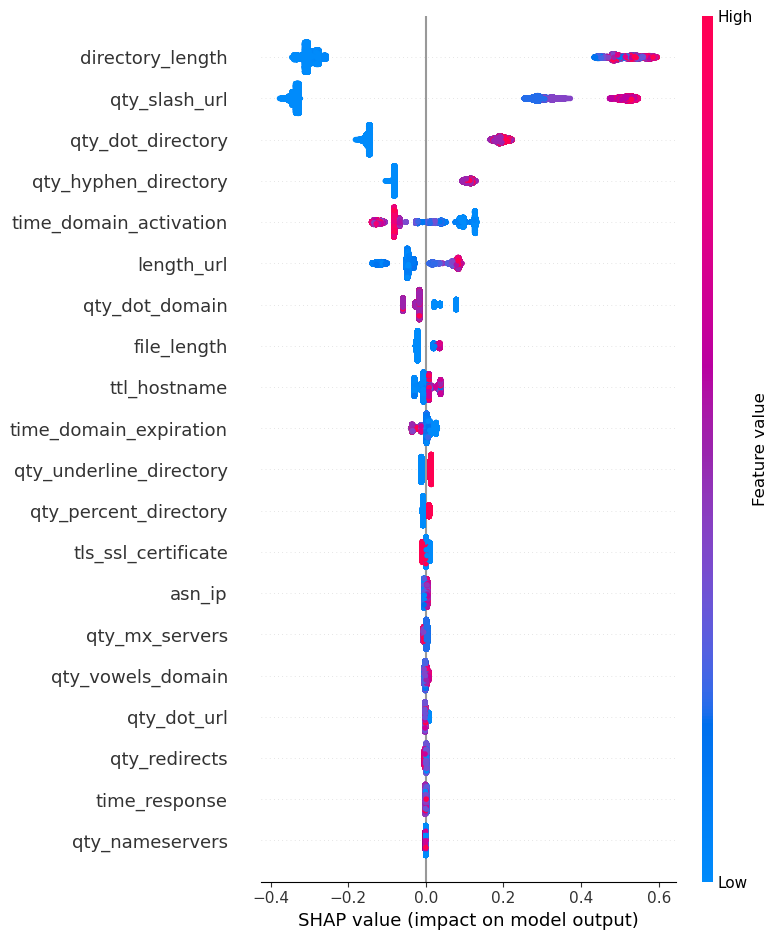

In [301]:

explainer = shap.TreeExplainer ( model=classifier )
shap_values = explainer.shap_values ( X_test )

shap.summary_plot ( shap_values[1], features=X_test )

# XGBOOST

In [302]:
# Create the XGBoost classifier model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

In [303]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the XGBoost classifier model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')  # Removed 'use_label_encoder'

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Calculate training accuracy
train_accuracy = xgb_model.score(X_train, y_train)

# Calculate testing accuracy
test_accuracy = xgb_model.score(X_test, y_test)

# Validate the model by checking the model accuracy with model.score
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

Train Accuracy: 0.984
Test Accuracy: 0.969


In [304]:
#print(xgb_model.feature_importances_)

#feature_names = [f'feature_{i}' for i in range(X_test.shape[1])]

# Set the feature names
#xgb_model.get_booster ().feature_names = feature_names

# Plot feature importances
#plt.figure ( figsize= ( 10, 150 ) )
#lot_importance ( xgb_model.get_booster(), importance_type='weight' )
#plt.show ()

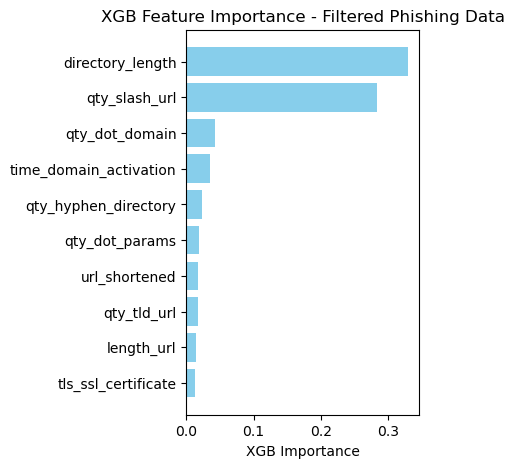

In [305]:
xgb_importances = xgb_model.feature_importances_
#pd.Series(importances, index=X.columns).sort_values()

xgb_feature_names = X.columns
xgb_feature_importance_df = pd.DataFrame({'Feature': xgb_feature_names, 'Importance': xgb_importances})

xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)
#print(feature_importance_df)

xgb_df_features = xgb_feature_importance_df.iloc[0:10, [0]].squeeze ()

#feature_importance_df["Feature"]
xgb_df_importances = xgb_feature_importance_df.iloc[0:10, [1]].squeeze ()
#print (df_importances)

plt.figure(figsize=(3, 5))
plt.barh(xgb_df_features, xgb_df_importances, color='skyblue')
plt.xlabel('XGB Importance')
plt.title('XGB Feature Importance - Filtered Phishing Data')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

# Hyperparameter Tuning From XGBoost



In [306]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Set up the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model using the grid search
grid_search.fit(X_train, y_train)

# Output the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the best model
best_model = grid_search.best_estimator_
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

print(f'Best Train Accuracy: {train_accuracy:.3f}')
print(f'Best Test Accuracy: {test_accuracy:.3f}')

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Train Accuracy: 0.996
Best Test Accuracy: 0.971
